## Import library

In [51]:
%run bert
%run utils.ipynb
%run feat

import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import linear_model 
from sklearn.metrics import cohen_kappa_score,mean_absolute_error,mean_squared_error,accuracy_score,explained_variance_score,r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna

## Load Data

In [13]:
loader = DataLoader()
d = loader.GetData('SHU')
d.head()

,用户ID,学号,姓名,班级,院系,任课教师,essay,score
0,1003248517,21122339,陈美希,2021-22春季通用学术英语B31012薛清期末,生命科学学院,1002658414(薛清),What makes the Western society baffled ...,11.5
1,1003247961,21121783,刘开颜,2021-22春季通用学术英语B31006杨兆明期末,计算机工程与科学学院,1002658423(杨兆明),"In this term,we have learned the passage ‘Ref...",11.7
2,1003248106,21121928,钱皓昀,2021-22春季通用学术英语B31043范金萍期末,机电工程与自动化学院,1002658426(范金萍),There is a huge difference between west and ...,11.1
3,1003249155,21122982,杨宸,2021-22春季通用学术英语B31031蔡俏兰期末,理学院,1002658419(蔡俏兰),"As is vividly eloborated in the article, Chine...",12.3
4,1003248516,21122338,和嘉懿,2021-22春季通用学术英语B31012薛清期末,材料科学与工程学院,1002658414(薛清),"As mentioned in the artical, the difference be...",10.0


In [14]:
sns.set_theme(style='darkgrid')

In [15]:
d['score'].describe()

count    1664.000000
mean       11.100000
std         0.996289
min         2.800000
25%        10.600000
50%        11.200000
75%        11.800000
max        13.300000
Name: score, dtype: float64

In [16]:
tcount = []
i=0
for e in d['essay']:
    i+= 1
    if i %100 == 0:
        print(i)
    ext = extractor.pass_text(e)
    f = ext.preprocess()
    tcount.append(f['n_token'])

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


In [17]:
d['token'] = tcount
d['token'].describe()

count    1664.000000
mean      148.208534
std        28.759339
min        10.000000
25%       133.000000
50%       146.000000
75%       157.000000
max       344.000000
Name: token, dtype: float64

In [26]:
d.loc[d['token'] ==10]

,用户ID,学号,姓名,班级,院系,任课教师,essay,score,token
729,1003248673,21122495,徐洋,2021-22春季通用学术英语B31003张苹期末,材料科学与工程学院,1002658417(张苹),After reading the passage Reflections of a Chi...,2.8,10


<AxesSubplot: xlabel='token', ylabel='Count'>

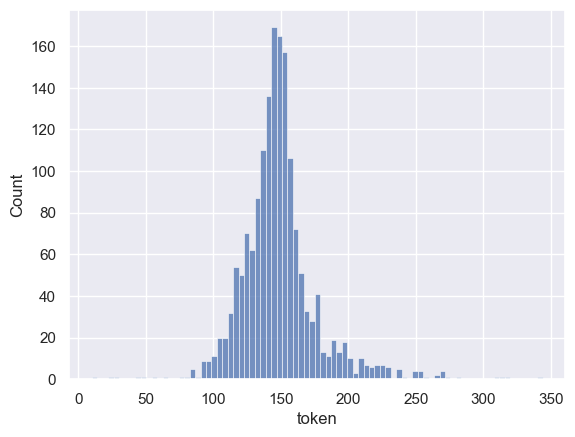

In [24]:
sns.histplot(d['token'])

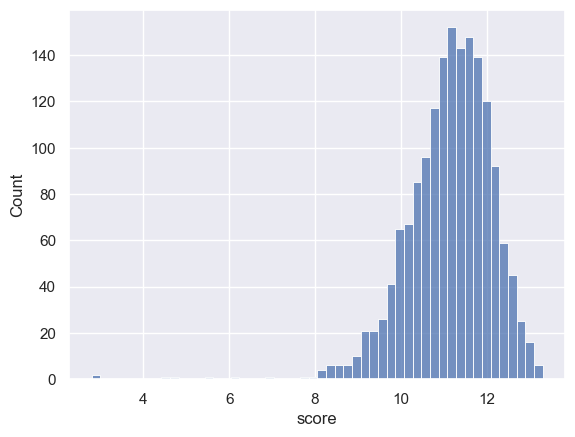

In [27]:
g = sns.histplot(d['score'])

## Model Inference

25m19.4s

In [28]:
EmbeddingFetcher = GetBERTEmbeddings(d['essay'],'model/deberta-v3-large')
EmbeddingFetcher.inf(stop=1500,SeqLen = 512 )

tokenized
0/1500, run:0
10/1500, run:0
20/1500, run:0
30/1500, run:0
40/1500, run:0
50/1500, run:0
60/1500, run:0
70/1500, run:0
80/1500, run:0
90/1500, run:0
100/1500, run:0
110/1500, run:0
120/1500, run:0
130/1500, run:0
140/1500, run:0
150/1500, run:0
160/1500, run:0
170/1500, run:0
180/1500, run:0
190/1500, run:0
200/1500, run:0
210/1500, run:0
220/1500, run:0
230/1500, run:0
240/1500, run:0
250/1500, run:0
260/1500, run:0
270/1500, run:0
280/1500, run:0
290/1500, run:0
300/1500, run:0
310/1500, run:0
320/1500, run:0
330/1500, run:0
340/1500, run:0
350/1500, run:0
360/1500, run:0
370/1500, run:0
380/1500, run:0
390/1500, run:0
400/1500, run:0
410/1500, run:0
420/1500, run:0
430/1500, run:0
440/1500, run:0
450/1500, run:0
460/1500, run:0
470/1500, run:0
480/1500, run:0
490/1500, run:0
500/1500, run:0
510/1500, run:0
520/1500, run:0
530/1500, run:0
540/1500, run:0
550/1500, run:0
560/1500, run:0
570/1500, run:0
580/1500, run:0
590/1500, run:0
600/1500, run:0
610/1500, run:0
620/1500,

### Clear cuda cache

In [4]:
del EmbeddingFetcher.model
torch.cuda.empty_cache()

## Extract Embeddings

In [78]:
x = EmbeddingFetcher.GetEmbeddings('MeanP')

## Split Train and Test data

In [79]:
x = [np.array(i).reshape(1024) for i in x]
TrainX,TestX = x[:1200],x[1200:]

In [80]:
TrainY,TestY = d['score'][:1200],d['score'][1200:]

## Hyper parameter tuning

In [8]:
def objective(trial):
    params = {"random_state":trial.suggest_categorical("random_state", [42]),           
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 1),  
        "max_depth" : trial.suggest_int("max_depth", 5, 15),
        "alpha" : trial.suggest_float('alpha',0.9,1),
    }
    error = []
    for i in range(6):
        model = xgb.XGBRegressor(**params)
        model.fit(TrainX,TrainY[i])
        PredY = model.predict(TestX)
        e = mean_squared_error(TestY[i],PredY,squared=False)
        error.append(e)
    mcrmse = sum(error)/6
    return mcrmse
#study = optuna.create_study()
#study.optimize(objective, n_trials=100) 

In [ ]:
from optuna.visualization.matplotlib import plot_optimization_history
#plot_optimization_history(study)

## No tuning

In [81]:
def objective():
    model = xgb.XGBRegressor(tree_method="hist",learning_rate=0.042)
    model.fit(TrainX,TrainY)
    PredY = model.predict(TestX)
    e = mean_squared_error(TestY,PredY,squared=False)
    ae = mean_absolute_error(TestY,PredY)
    return [e,ae,model,PredY]
res = objective()

In [82]:
res[0],res[1]

(0.5075225506166802, 0.388357086839347)

In [84]:
r2_score(TestY,res[-1])

0.7065017305712844

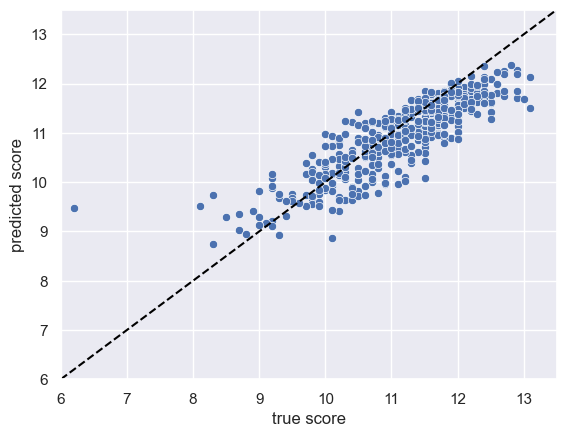

In [83]:
g = sns.scatterplot(x=TestY,y=res[-1])
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((6,13.5))
g.set_xlim((6,13.5))
g = sns.lineplot(x=[6,13.5],y=[6,13.5],color='black')
g.lines[0].set_linestyle("--")

## Features only

In [ ]:
spacy.prefer_gpu = False
spacy.prefer_gpu

False

767m48.5s

In [ ]:
x1 = []
c= 0
for essay in d['essay']:
    ext = FeatureExtraction(essay)
    i = ext.GetFine()
    c += 1
    x1.append(i)
    if c % 10 == 0:
        print(c)
    with open('d.txt','a') as f:
        f.write(','.join([str(f) for f in i]))
        f.write('\n')

In [73]:
x1 = []
with open('d.txt') as f:
    for l in f.readlines():
        feat = [float(i) for i in l.split(',')]
        x1.append(feat)

In [74]:
TrainX,TestX = x1[:1200],x1[1200:]

In [75]:
res = objective()
res[0],res[1]

(0.8103190011996333, 0.6434846528645219)

In [77]:
r2_score(TestY,res[-1])

0.2518186080375956

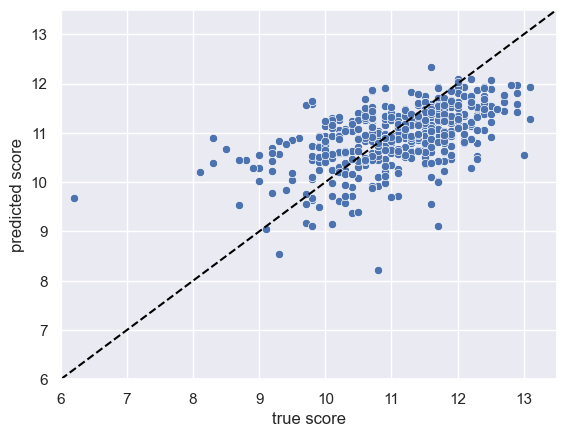

In [76]:
g = sns.scatterplot(x=TestY,y=res[-1])
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((6,13.5))
g.set_xlim((6,13.5))
g = sns.lineplot(x=[6,13.5],y=[6,13.5],color='black')
g.lines[0].set_linestyle("--")

## Features+embeddings

In [69]:
x2 = []
for i in range(1664):
    a = np.concatenate((x[i],x1[i]))
    x2.append(a)
TrainX,TestX = x2[:1200],x2[1200:]

In [70]:
res = objective()
res[0],res[1]

(0.4876535201193204, 0.36981489041755944)

In [71]:
r2_score(TestY,res[-1])

0.729032263171189

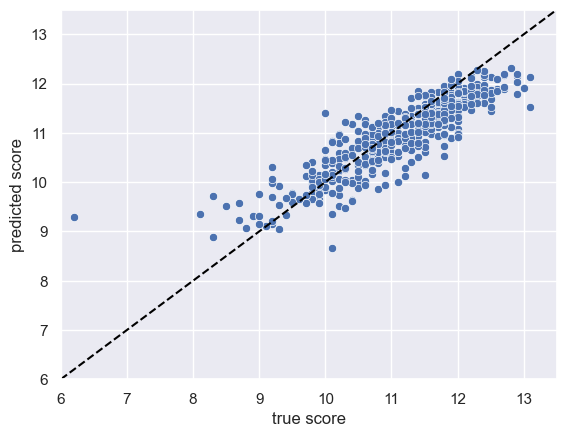

In [72]:
g = sns.scatterplot(x=TestY,y=res[-1])
g.set_ylabel('predicted score')
g.set_xlabel('true score')
g.set_ylim((6,13.5))
g.set_xlim((6,13.5))
g = sns.lineplot(x=[6,13.5],y=[6,13.5],color='black')
g.lines[0].set_linestyle("--")

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

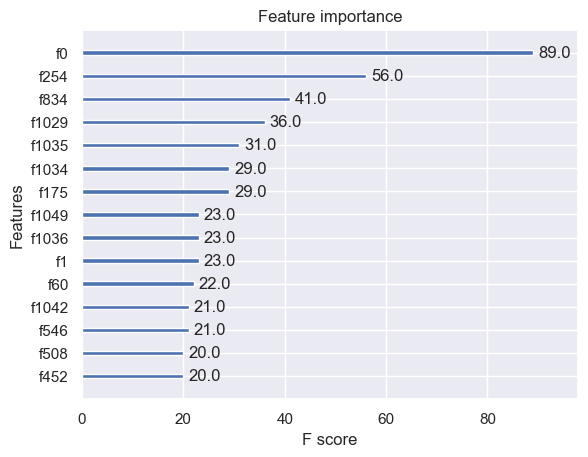

In [62]:
xgb.plot_importance(res[-2],max_num_features=15)

### L2

In [63]:
with open('c1.txt') as f:
    l2 = f.readlines()[1:]
xl = dict()
for l in l2:
    i = int(l.split(',')[0].split('.')[0])
    feat = l.rstrip('\n').split(',')[-14:]
    feat = [float(s) for s in feat]
    xl[i] = feat
x4 = []
for i in range(1664):
    x4.append(xl[i])

In [64]:
TrainX,TestX = x4[:1200],x4[1200:]

In [65]:
res = objective()
res[0],res[1]

(0.916489195262793, 0.737171420146679)

In [66]:
x5 = []
for i in range(1664):
    a = np.concatenate((x[i],x4[i]))
    x5.append(a)
TrainX,TestX = x5[:1200],x5[1200:]

In [67]:
res = objective()
res[0],res[1]

(0.5022444181148309, 0.3855761795208372)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

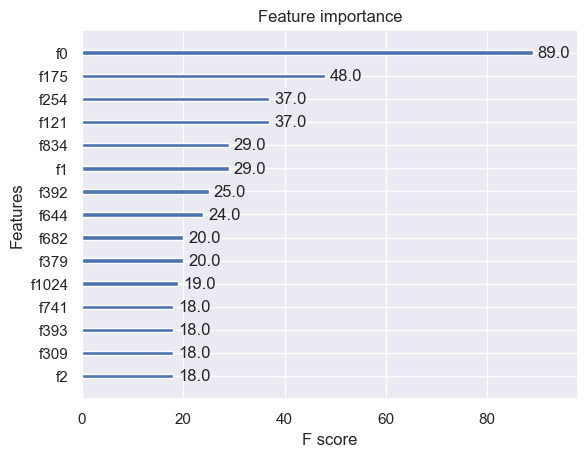

In [68]:
xgb.plot_importance(res[-2],max_num_features=15)